In [3]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, SpatialDropout1D,Bidirectional,Conv1D, GlobalMaxPooling1D
from tensorflow.keras.regularizers import l2
import keras


In [2]:
movie=pd.read_csv('CleanedMovies.csv')
movie['review']=movie['review'].apply(ast.literal_eval)

In [3]:
movie['review']=movie['review'].apply(lambda x : ' '.join(x))
movie

,review,sentiment
0,one reviewer mentioned watching 1 oz episode y...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically there family little boy jake think t...,0
4,petter matteis love time money visually stunni...,1
...,...,...
49995,thought movie right good job wasnt creative or...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,catholic taught parochial elementary school nu...,0
49998,im going disagree previous comment side maltin...,0


In [4]:
label = movie['sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(
    movie['review'], label, test_size=0.2, random_state=2023)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=2023)

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

ldim = 200
trunc = 'post'
padder = 'post'
not_inDic = '<OOV>' 
maxVoc = 8000
eDim = 150


In [6]:
tokenizer = Tokenizer(num_words = maxVoc, 
                      oov_token=not_inDic,
                      char_level=False)
tokenizer.fit_on_texts(x_train)

In [7]:
word_index = tokenizer.word_index
total_words = len(set(word_index))
total_words

170350

In [8]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = ldim,
                                padding = padder,
                                truncating = trunc)
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = ldim,
                               padding = padder,
                               truncating = trunc)
val_sequences = tokenizer.texts_to_sequences(x_val)
val_padded = pad_sequences(val_sequences, 
                           maxlen=ldim, 
                           padding=padder, 
                           truncating=trunc)

In [9]:
model=Sequential()
model.add(Embedding(maxVoc,eDim,))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(22,activation='relu'))
model.add(Dense(11,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf

initial_learning_rate = 0.0015
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=False
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
num_epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)
history = model.fit(training_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(val_padded,y_val),
                     callbacks =[early_stop],
                     batch_size=60,
                     verbose=1)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 99s 162ms/step - accuracy: 0.6753 - loss: 0.5924 - val_accuracy: 0.7837 - val_loss: 0.4803
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 77s 128ms/step - accuracy: 0.7868 - loss: 0.4726 - val_accuracy: 0.8865 - val_loss: 0.2832
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 75s 126ms/step - accuracy: 0.9015 - loss: 0.2579 - val_accuracy: 0.8875 - val_loss: 0.2704
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 71s 118ms/step - accuracy: 0.9292 - loss: 0.1928 - val_accuracy: 0.8905 - val_loss: 0.2883
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 71s 119ms/step - accuracy: 0.9482 - loss: 0.1504 - val_accuracy: 0.8838 - val_loss: 0.3138


In [12]:
from sklearn.metrics import accuracy_score
prediction = model.predict(testing_padded)
pred_labels = []
for i in prediction:
    if i > 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(y_test,pred_labels))

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Accuracy of prediction on test set :  0.8879


In [13]:
model.save('models/LSTM/LSTM.keras')
model.save_weights('models/LSTM/LSTM.weights.h5')

In [4]:
model=keras.saving.load_model('models/LSTM/LSTM.keras')
model.summary()
print(model.count_params())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (60, 200, 150)         │     1,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (60, 200, 150)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (60, 200)              │       200,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (60, 200)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (60, 22)               │         4,422 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (60, 11)               │           253 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (60, 1)                │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,216,462 (16.08 MB)

 Trainable params: 1,405,487 (5.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,810,975 (10.72 MB)

1405487


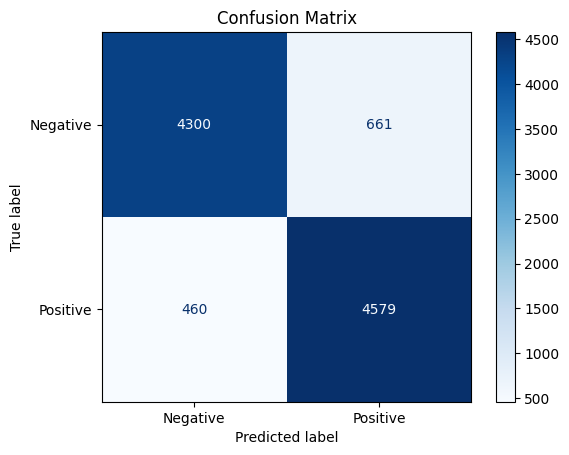

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred_labels)
labels = ['Negative', 'Positive']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

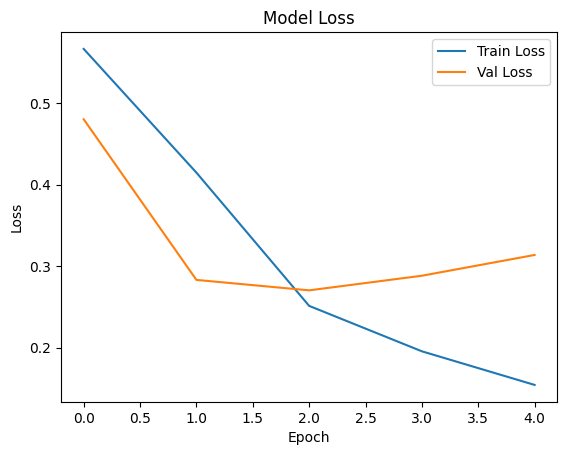

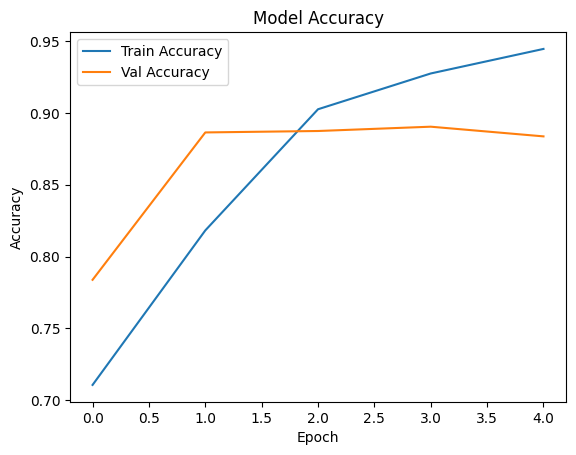

In [16]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()